# **Elaborato Progettuale**
## _Tecniche di Machine Learning e Deep Learning per la Predizione dei Fattori di Rischio del Tumore Cervicale_
### Apprendimento Automatico e Apprendimento Profondo
#### Università San Raffaele Roma

##### Candidato: Daniele Iodice

##### Matricola: 0322500045

###### Anno Accademico: 2025/2026

### 1) Importazione delle librerie

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve
)

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from ucimlrepo import fetch_ucirepo

/opt/anaconda3/envs/conda_interpreter/lib/python3.13/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


### 2) Caricamento del dataset

In [2]:
# Caricamento del dataset
dataset = fetch_ucirepo(id=383)

# Feature e target
X = dataset.data.features
y = X["Biopsy"]          # Target scelto
X = X.drop(columns=["Biopsy"])

# Informazioni sul dataset
print(dataset.metadata)
print(dataset.variables)

{'uci_id': 383, 'name': 'Cervical Cancer (Risk Factors)', 'repository_url': 'https://archive.ics.uci.edu/dataset/383/cervical+cancer+risk+factors', 'data_url': 'https://archive.ics.uci.edu/static/public/383/data.csv', 'abstract': 'This dataset focuses on the prediction of indicators/diagnosis of cervical cancer. The features cover demographic information, habits, and historic medical records.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 858, 'num_features': 36, 'feature_types': ['Integer', 'Real'], 'demographics': ['Age', 'Other'], 'target_col': None, 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2017, 'last_updated': 'Sun Mar 10 2024', 'dataset_doi': '10.24432/C5Z310', 'creators': ['Kelwin Fernandes', 'Jaime Cardoso', 'Jessica Fernandes'], 'intro_paper': {'ID': 419, 'type': 'NATIVE', 'title': 'Transfer Learning with Partial Observability Applied to Cervi

### 3) Preprocessing dei dati

In [3]:
# Gestione dei dati mancanti
# Sostituzione dei valori "?" con NaN
X = X.replace("?", np.nan)

# Conversione in formato numerico
X = X.astype(float)

# Riempimento dei valori mancanti tramite mediana
X = X.fillna(X.median())

# Controllo colonne costanti
n_unique = X.nunique().sort_values()
n_unique.name = "Numero di valori"
print(n_unique)

# Rimozione colonne costanti (una sola classe)
X = X.loc[:, X.nunique() > 1]

STDs:AIDS                              1
STDs:cervical condylomatosis           1
STDs:syphilis                          2
Hinselmann                             2
Dx                                     2
Dx:HPV                                 2
Dx:CIN                                 2
Dx:Cancer                              2
STDs:HPV                               2
STDs:Hepatitis B                       2
STDs:HIV                               2
STDs:molluscum contagiosum             2
STDs:genital herpes                    2
STDs:pelvic inflammatory disease       2
Schiller                               2
STDs:vulvo-perineal condylomatosis     2
Citology                               2
STDs:condylomatosis                    2
Smokes                                 2
STDs                                   2
STDs:vaginal condylomatosis            2
IUD                                    2
Hormonal Contraceptives                2
STDs: Number of diagnosis              4
STDs (number)   

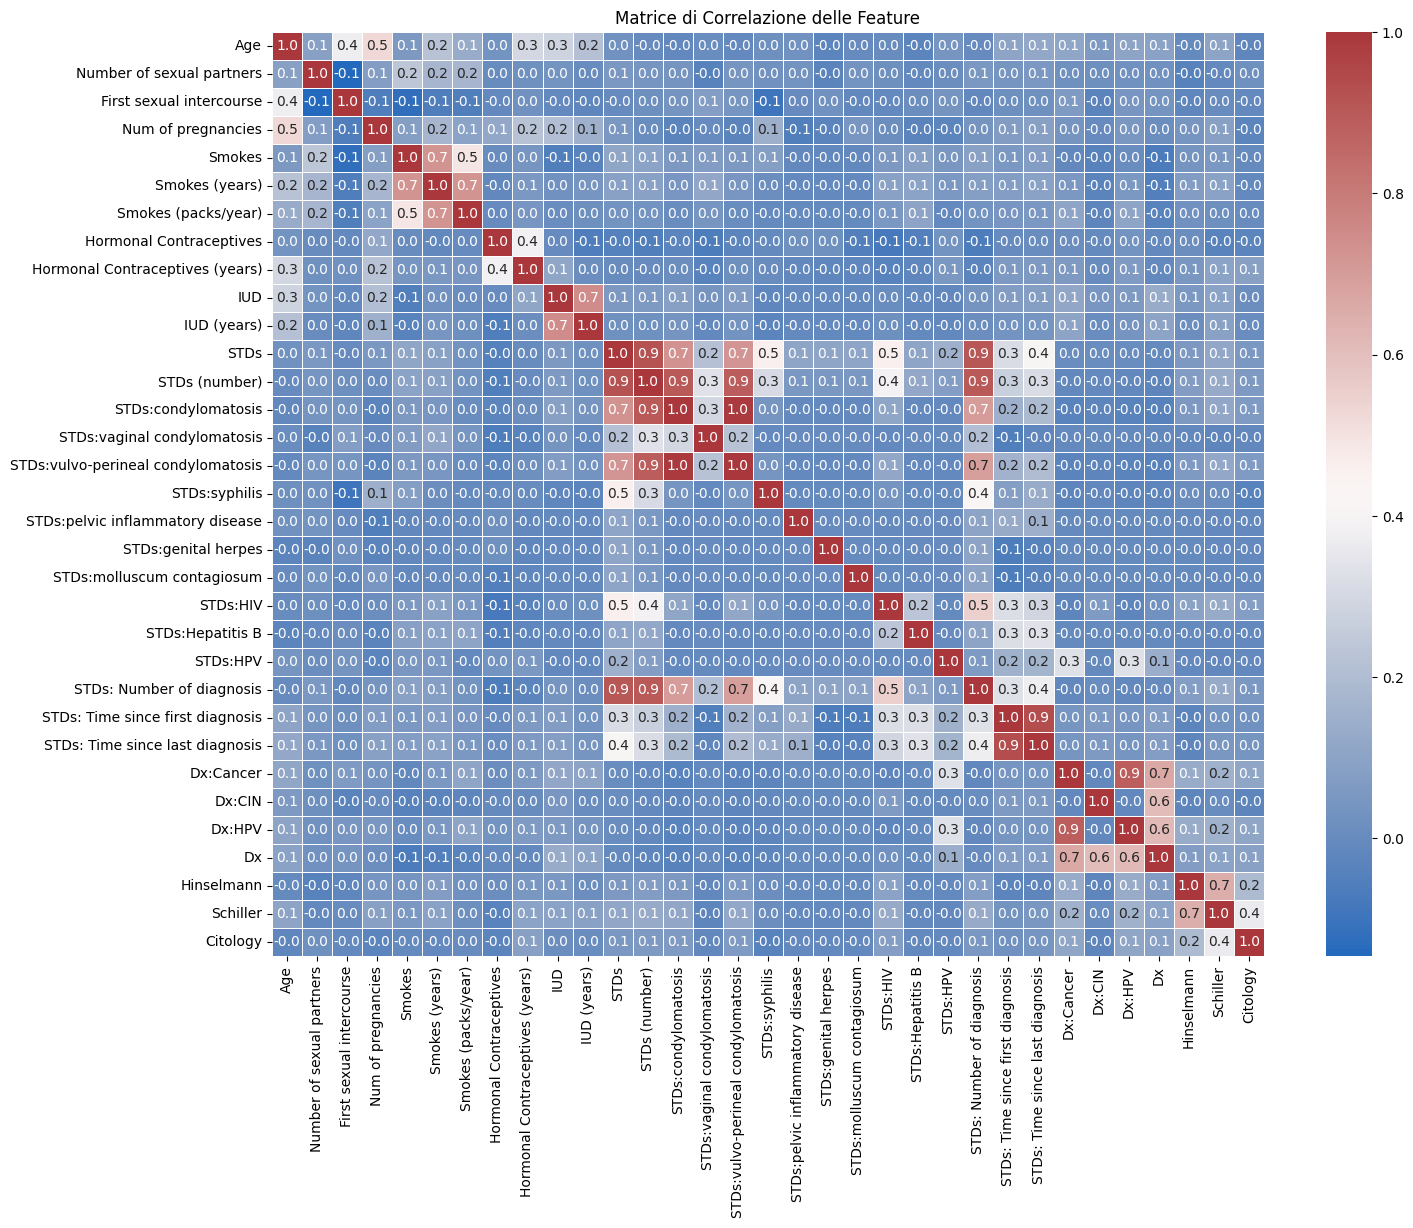

In [4]:
# Matrice di correlazione
plt.figure(figsize=(16, 12))
sns.heatmap(
    X.corr(),
    annot=True,
    fmt=".1f",
    cmap="vlag",
    linewidths=0.5
)
plt.title("Matrice di Correlazione delle Feature")
plt.show()

### 4) Standardizzazione delle feature

In [5]:
# Standardizzazione delle feature
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### 5) Analisi esplorativa con PCA (Principal Component Analysis)

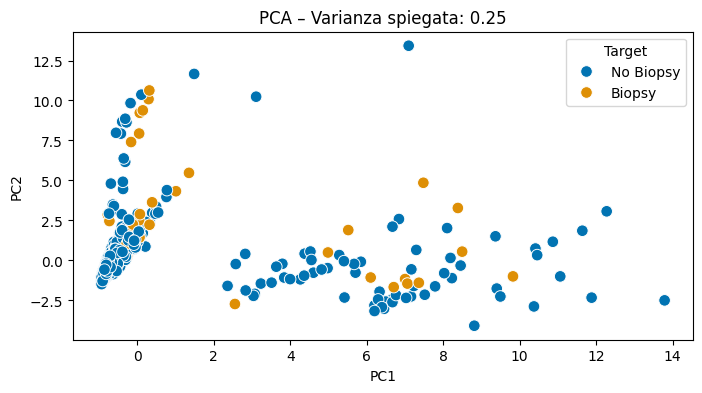

Varianza PC1: 15.48%
Varianza PC2: 9.16%


In [6]:
# PCA: due dimensioni
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# DataFrame per la visualizzazione
df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_pca["Target"] = y.map({0: "No Biopsy", 1: "Biopsy"})

# Scatter plot
plt.figure(figsize=(8, 4))
sns.scatterplot(
    data=df_pca,
    x="PC1",
    y="PC2",
    hue="Target",
    palette="colorblind",
    s=70
)
plt.title(f"PCA – Varianza spiegata: {pca.explained_variance_ratio_.sum():.2f}")
plt.show()

print(f"Varianza PC1: {pca.explained_variance_ratio_[0]:.2%}")
print(f"Varianza PC2: {pca.explained_variance_ratio_[1]:.2%}")

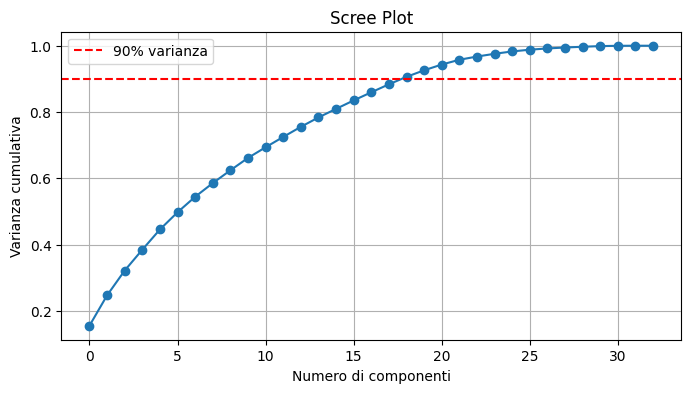

In [7]:
# Scree plot
pca_full = PCA().fit(X_scaled)
var_cum = np.cumsum(pca_full.explained_variance_ratio_)

plt.figure(figsize=(8, 4))
plt.plot(var_cum, marker="o")
plt.axhline(0.9, color="red", linestyle="--", label="90% varianza")
plt.xlabel("Numero di componenti")
plt.ylabel("Varianza cumulativa")
plt.title("Scree Plot")
plt.legend()
plt.grid(True)
plt.show()

### 6) Suddivisione del dataset

In [8]:
# Suddivisione del dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

### 7) Addestramento e valutazione

In [9]:
# Funzione valutazione dei modelli di classificazione
def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)              # classi predette
    y_prob = model.predict_proba(X_test)[:,1]   # probabilità classe positiva (ROC AUC)

    # Accuracy, classification report
    print(f"\n{name}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
    print(classification_report(y_test, y_pred, target_names=["No Biopsy", "Biopsy"]))

    # Matrice di confusione
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=["No Biopsy", "Biopsy"]).plot(cmap="Blues")
    plt.title(f"Matrice di Confusione – {name}")
    plt.grid(False)
    plt.show()

    # ROC AUC
    roc_auc = roc_auc_score(y_test, y_prob)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    print(f"ROC AUC: {roc_auc}")

    # Curva ROC
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], "k--")
    plt.title(f"ROC Curve – {name}")
    plt.xlabel("FPR (False Positive Rate)")
    plt.ylabel("TPR (True Positive Rate)")
    plt.legend()
    plt.grid(True)
    plt.show()

#### Gaussian Naïve Bayes


Gaussian Naïve Bayes
Accuracy: 9.30%
              precision    recall  f1-score   support

   No Biopsy       1.00      0.03      0.06       241
      Biopsy       0.07      1.00      0.13        17

    accuracy                           0.09       258
   macro avg       0.53      0.51      0.09       258
weighted avg       0.94      0.09      0.06       258



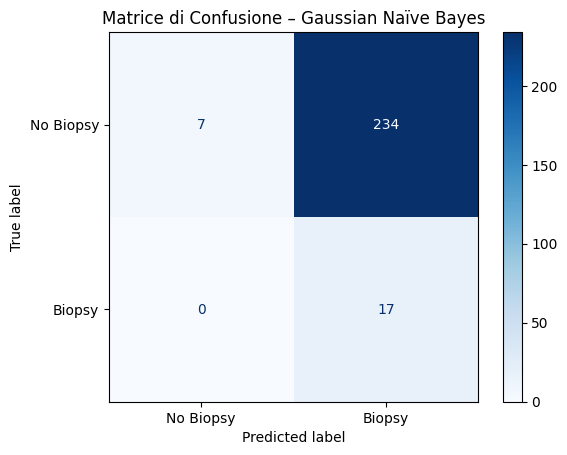

ROC AUC: 0.8439101781791555


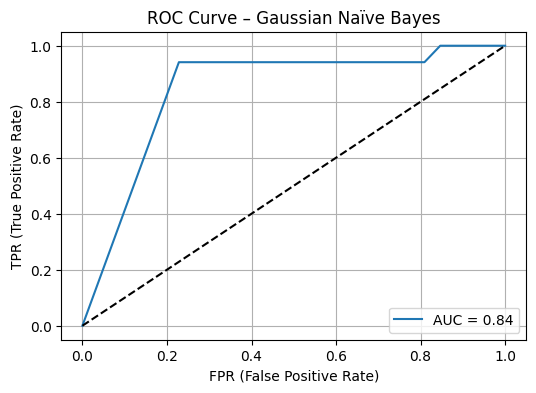

In [10]:
# Definizione del classificatore
nb = GaussianNB()

# Addestramento
nb.fit(X_train, y_train)

# Valutazione
evaluate_model(nb, X_test, y_test, "Gaussian Naïve Bayes")

#### Logistic Regression


Logistic Regression
Accuracy: 94.19%
              precision    recall  f1-score   support

   No Biopsy       0.98      0.95      0.97       241
      Biopsy       0.54      0.76      0.63        17

    accuracy                           0.94       258
   macro avg       0.76      0.86      0.80       258
weighted avg       0.95      0.94      0.95       258



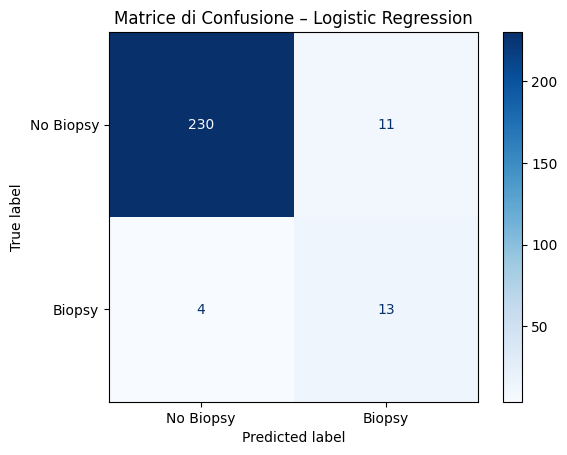

ROC AUC: 0.9321454722968024


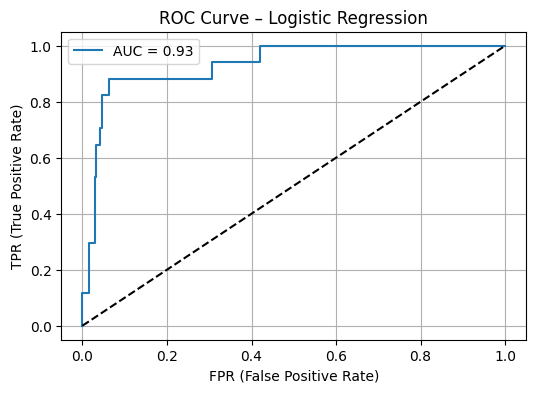

In [11]:
# Definizione del classificatore
lr = LogisticRegression(
    max_iter=200,
    class_weight="balanced",   # gestione dataset sbilanciato
    random_state=42
)

# Addestramento
lr.fit(X_train, y_train)

# Valutazione
evaluate_model(lr, X_test, y_test, "Logistic Regression")

#### Support Vector Machine (SVM)


SVM
Accuracy: 93.80%
              precision    recall  f1-score   support

   No Biopsy       0.97      0.96      0.97       241
      Biopsy       0.53      0.59      0.56        17

    accuracy                           0.94       258
   macro avg       0.75      0.78      0.76       258
weighted avg       0.94      0.94      0.94       258



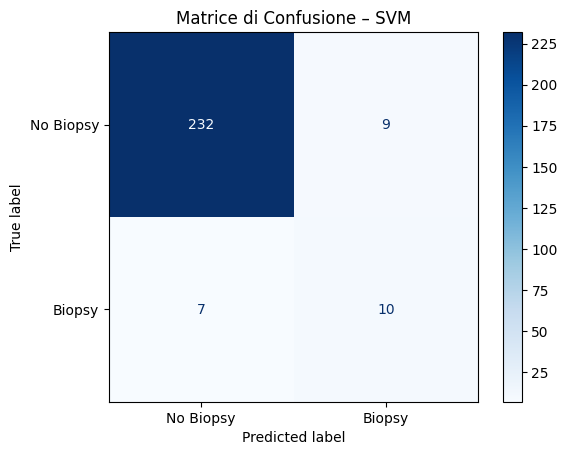

ROC AUC: 0.9421527947278496


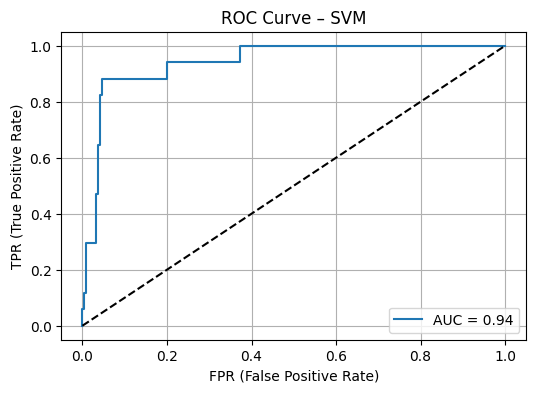

In [12]:
# Definizione del classificatore
svm = SVC(
    kernel="rbf",
    class_weight="balanced",   # gestione dataset sbilanciato
    probability=True,
    random_state=42
)

# Addestramento
svm.fit(X_train, y_train)

# Valutazione
evaluate_model(svm, X_test, y_test, "SVM")

#### Random Forest


Random Forest
Accuracy: 94.57%
              precision    recall  f1-score   support

   No Biopsy       0.96      0.98      0.97       241
      Biopsy       0.64      0.41      0.50        17

    accuracy                           0.95       258
   macro avg       0.80      0.70      0.74       258
weighted avg       0.94      0.95      0.94       258



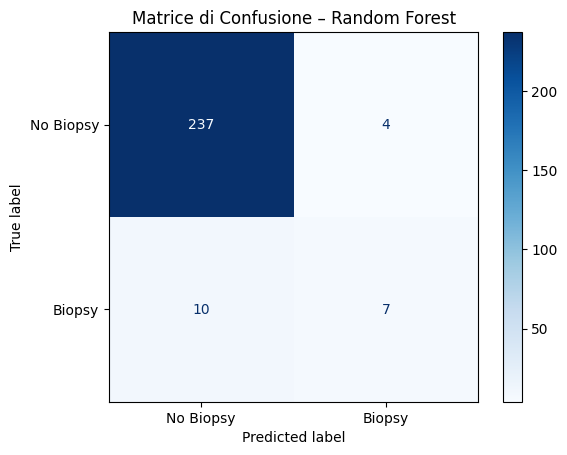

ROC AUC: 0.9592384671711008


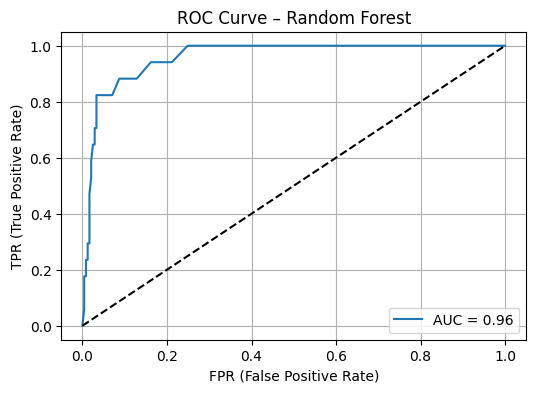

In [13]:
# Definizione del classificatore
rf = RandomForestClassifier(
    n_estimators=100,
    class_weight="balanced",   # gestione dataset sbilanciato
    random_state=42
)

# Addestramento
rf.fit(X_train, y_train)

# Valutazione
evaluate_model(rf, X_test, y_test, "Random Forest")

Schiller                              0.403025
Hinselmann                            0.108516
Age                                   0.066602
First sexual intercourse              0.061868
Citology                              0.061780
Hormonal Contraceptives (years)       0.044169
Num of pregnancies                    0.043977
Number of sexual partners             0.040906
Dx                                    0.031048
IUD (years)                           0.020537
Dx:CIN                                0.020267
Dx:HPV                                0.013808
IUD                                   0.009801
Smokes (packs/year)                   0.008676
STDs: Time since first diagnosis      0.008289
Hormonal Contraceptives               0.007886
Smokes (years)                        0.006845
STDs:HIV                              0.006806
STDs (number)                         0.006168
STDs: Number of diagnosis             0.005415
Dx:Cancer                             0.005186
STDs: Time si

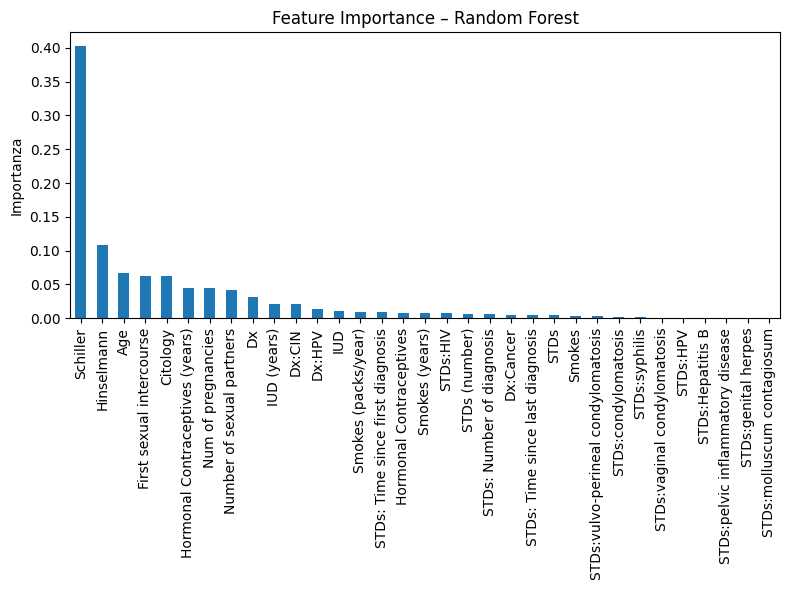

In [14]:
# Importanza delle feature
feature_imp = pd.Series(
    rf.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

print(feature_imp)

plt.figure(figsize=(8, 6))
feature_imp.plot(kind="bar")
plt.title("Feature Importance – Random Forest")
plt.ylabel("Importanza")
plt.tight_layout()
plt.show()

### 8) Deep Learning

In [15]:
# Selezione del seed
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Preparazione dei dati (stessi dati dei modelli shallow)
input_dim = X_train.shape[1]  # numero di feature

#### Costruzione del modello

In [16]:
# Costruzione del modello di rete neurale
model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

# Compilazione del modello
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Configurazione TensorBoard
log_dir = "logs/dl_biopsy"
tensorboard_cb = keras.callbacks.TensorBoard(log_dir=log_dir)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 561 (2.19 KB)

 Trainable params: 561 (2.19 KB)

 Non-trainable params: 0 (0.00 B)

#### Addestramento del modello

In [17]:
# Addestramento del modello
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=16,
    callbacks=[tensorboard_cb],
    verbose=1
)

# Visualizzazione dei log con TensorBoard
%load_ext tensorboard
%tensorboard --logdir logs/dl_biopsy

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5500 - loss: 0.6983 - val_accuracy: 0.6333 - val_loss: 0.6385
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8271 - loss: 0.5635 - val_accuracy: 0.8417 - val_loss: 0.5242
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9250 - loss: 0.4613 - val_accuracy: 0.8833 - val_loss: 0.4377
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9271 - loss: 0.3778 - val_accuracy: 0.9000 - val_loss: 0.3700
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9375 - loss: 0.3086 - val_accuracy: 0.9083 - val_loss: 0.3192
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9458 - loss: 0.2534 - val_accuracy: 0.9250 - val_loss: 0.2826
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9542 - loss: 0.2101 - val_accuracy: 0.9250 - val_loss: 0.2575
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9563 - loss: 0.1771 - val_accuracy: 0.9250 - v

#### Valutazione del modello

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Accuracy: 93.41%
              precision    recall  f1-score   support

   No Biopsy       0.97      0.95      0.96       241
      Biopsy       0.50      0.65      0.56        17

    accuracy                           0.93       258
   macro avg       0.74      0.80      0.76       258
weighted avg       0.94      0.93      0.94       258



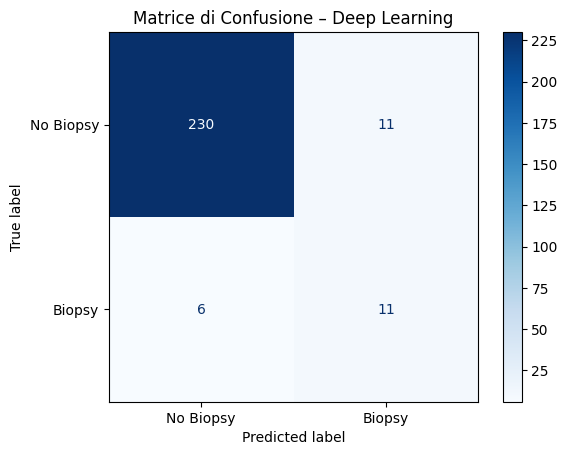

ROC AUC: 0.94


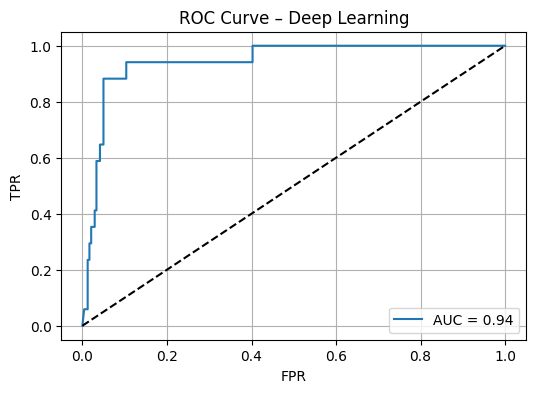

In [18]:
# Valutazione sul test set
y_pred_prob = model.predict(X_test).flatten()   # Converte gli output per scikit-learn
y_pred = (y_pred_prob >= 0.5).astype(int)       # Soglia di decisione Biopsy-No Biopsy

# Accuracy e classification report
print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print(classification_report(y_test, y_pred, target_names=["No Biopsy", "Biopsy"]))

# Matrice di confusione
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=["No Biopsy", "Biopsy"]).plot(cmap="Blues")
plt.title("Matrice di Confusione – Deep Learning")
plt.show()

# ROC AUC e curva ROC
roc_auc = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
print(f"ROC AUC: {roc_auc:.2f}")

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC Curve – Deep Learning")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.grid(True)
plt.show()